In [3]:
import numba
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
@numba.njit
def velocity(z1,z0,gamma):
    """
    parameters:
    
    z0 : position of the vortex
    z1 : complex point where velocity is to be calculated
    gamma : strength of the vortex placed at z0
    
    Returns:
    vel : velocity at point z1 due to the vortex placed at z0
    """
    
    dz = z1 - z0
    
    phi = ((gamma)/(2*np.pi*dz))*complex(0,-1)
    
    u = phi.real
    v = (-1)*phi.imag
    
    return u , v
    

In [5]:
@numba.njit
def euler_update( x , v , dt):
    return x + v*dt

In [6]:
@numba.njit
def net_velocity(vortex, vortexs, gammas):
    u = 0
    v = 0
    curr_idx = np.argmin(np.abs(vortexs - vortex))
    for i,z0 in enumerate(vortexs):
        if curr_idx != i :
            u_temp , v_temp  = velocity(vortex,z0,gammas[i])
            u = u + u_temp
            v = v + v_temp
    return complex(u , v)

In [7]:
@numba.njit
def rk2_update(x,u1,u2,dt):
    return x + (dt/2)*(u1 + u2)

In [8]:
@numba.njit
def simulate(vortexs , gammas , num_iter , dt , mode="euler" ):
    num_vortex = len(vortexs)
    path = np.zeros((num_iter,num_vortex),dtype=np.complex128)
    path[0,:] = vortexs.copy()
    
    if mode == "euler":
        for t in range(num_iter):
            vel = np.zeros(num_vortex,dtype=np.complex128)
            for i,vortex in enumerate(vortexs):
                vel[i] = net_velocity(vortex,vortexs,gammas)
            vortexs = euler_update(vortexs,vel,dt)
            path[t,:] = vortexs.copy()
        
        return path
        
    elif mode == "rk2":
        for t in range(num_iter):
            u1 =  np.zeros(num_vortex,dtype=np.complex128)
            u2 = np.zeros(num_vortex,dtype=np.complex128)
            for i,vortex in enumerate(vortexs):
                u1[i] = net_velocity(vortex,vortexs,gammas)
                vortex_temp = euler_update(vortex,u1[i],dt)
                u2[i] = net_velocity(vortex_temp,vortexs,gammas)
            vortexs = rk2_update(vortexs,u1,u2,dt)
            path[t,:] = vortexs.copy()
            
        return path

In [9]:
def plot(path):
    plt.plot(path[:,:].real,path[:,:].imag)

In [10]:
def plot_last(path):
    plt.plot(path[-1,:].real,path[-1,:].imag)

In [11]:
@numba.njit
def get_gamma(y):
    gamma = (4*y)/(np.sqrt(1 - 4*np.square(y)))
    
    return gamma

time taken :  7.630751848220825


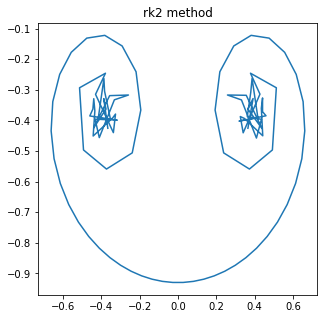

In [12]:
num_vortex = 100
dx = 1/num_vortex
x = np.array(np.linspace(-0.5 + dx/2 ,0.5 - dx/2 ,num_vortex))
y = np.zeros_like(x)

vortexs = x + 1j*y

gammas = 4*x*dx/(np.sqrt(1 - 4*np.square(x)))

t = 2
dt = 0.001
num_iter = int(t/dt)


a = time.time()

# plt.figure()
# path = simulate(vortexs , gammas , num_iter , dt, mode="euler")
# plt.title("Euler method")
# plot(path)

plt.figure(figsize=(5,5))
path = simulate(vortexs , gammas , num_iter , dt, mode="rk2")
plt.title("rk2 method")
plot_last(path)

print("time taken : ", time.time() - a)

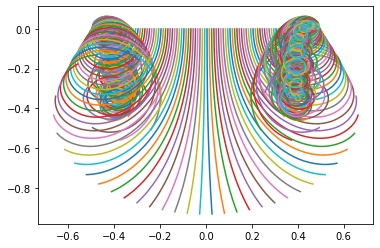

In [13]:
plot(path)

## Implementing kransy blob

In [14]:
@numba.njit
def krasny_velocity(z1,z0,gamma,delta):
    """
    parameters:
    
    z0 : position of the vortex
    z1 : complex point where velocity is to be calculated
    gamma : strength of the vortex placed at z0
    
    Returns:
    vel : velocity at point z1 due to the vortex placed at z0
    """
    
    dz = z1 - z0
    x = dz.real
    y = dz.imag
    
    phi = (gamma/(2*np.pi*(x*x + y*y + delta*delta)))*complex(-y,-x)
    
    u = phi.real
    v = (-1)*phi.imag
    
    return u , v
    

In [15]:
@numba.njit
def krasny_net_velocity(vortex, vortexs, gammas, deltas):
    u = 0
    v = 0
    curr_idx = np.argmin(np.abs(vortexs - vortex))
    for i,z0 in enumerate(vortexs):
        if curr_idx != i :
            u_temp , v_temp  = krasny_velocity(vortex,z0,gammas[i],deltas[i])
            u = u + u_temp
            v = v + v_temp
    return complex(u , v)

In [16]:
@numba.njit
def euler_update( x , v , dt):
    return x + v*dt

In [17]:
@numba.njit
def rk2_update(x,u1,u2,dt):
    return x + (dt/2)*(u1 + u2)

In [18]:
@numba.njit
def simulate(vortexs , gammas , deltas , num_iter , dt ):
    num_vortex = len(vortexs)
    path = np.zeros((num_iter,num_vortex),dtype=np.complex128)
    path[0,:] = vortexs.copy()

    for t in range(num_iter):
        u1 =  np.zeros(num_vortex,dtype=np.complex128)
        u2 = np.zeros(num_vortex,dtype=np.complex128)
        for i,vortex in enumerate(vortexs):
            u1[i] = krasny_net_velocity(vortex,vortexs,gammas,deltas)
            vortex_temp = euler_update(vortex,u1[i],dt)
            u2[i] = krasny_net_velocity(vortex_temp,vortexs,gammas,deltas)
        vortexs = rk2_update(vortexs,u1,u2,dt)
        path[t,:] = vortexs.copy()

    return path

In [19]:
def plot(path):
    plt.plot(path[:,:].real,path[:,:].imag)

In [31]:
def plot_last(path):
    plt.plot(path[-1,:].real,path[-1,:].imag,'-b')
    plt.plot(path[0,:].real,path[0,:].imag,'-r')

Delta is : 0.05
time taken :  2.628347635269165


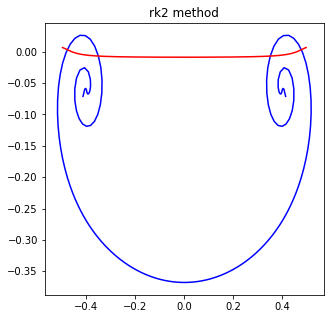

In [21]:
num_vortex = 200 # from the paper  krasny-87
dx = 1/num_vortex
x = np.array(np.linspace( -0.5 + dx/2 , 0.5 - dx/2 , num_vortex ))
y = np.zeros_like(x)

vortexs = x + 1j*y

gammas = 4*x*dx/(np.sqrt(1 - 4*np.square(x)))
delta = dx*10
print("Delta is :",delta)
# delta = 0.05  # from the paper krasny-87
deltas = np.array([delta]*len(x))

t = 0.5  # in seconds
dt = 0.01
num_iter = int(t/dt)


a = time.time()

# plt.figure()
# path = simulate(vortexs , gammas , num_iter , dt, mode="euler")
# plt.title("Euler method")
# plot(path)

plt.figure(figsize=(5,5))
path = simulate(vortexs , gammas , deltas , num_iter , dt)
plt.title("rk2 method")
plot_last(path)

print("time taken : ", time.time() - a)

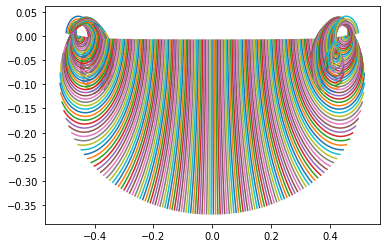

In [22]:
plot(path)

## Sine curve distribution 

time taken :  1.4870154857635498


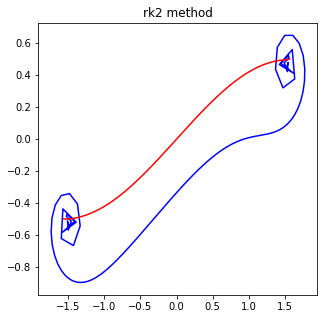

In [37]:
num_vortex = 200 # from the paper  krasny-87
dx = 1/num_vortex
x = np.array(np.linspace( -1*np.pi/2 + dx/2 , np.pi/2 - dx/2 , num_vortex ))
y = 0.5*np.sin(x)
dy = y[2] - y[1]

vortexs = x + 1j*y

gammas = 4*y*dy/(np.sqrt(1 - 4*np.square(y)))
# delta = dx*10
# print("Delta is :",delta)
delta = 0.05  # from the paper krasny-87
deltas = np.array([delta]*len(x))

t = 5  # in seconds
dt = 0.01
num_iter = int(t/dt)


a = time.time()

# plt.figure()
# path = simulate(vortexs , gammas , num_iter , dt, mode="euler")
# plt.title("Euler method")
# plot(path)

plt.figure(figsize=(5,5))
path = simulate(vortexs , gammas , deltas , num_iter , dt)
plt.title("rk2 method")
plot_last(path)

print("time taken : ", time.time() - a)